In [38]:
import numpy as np
from astropy import units as u
from astropy import time
from astropy import coordinates as c

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import propagate
from poliastro.examples import iss
import matplotlib.pyplot as plt
from poliastro import iod
from poliastro.bodies import Earth, Mars, Sun
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
from poliastro.earth.atmosphere import COESA76
from poliastro.twobody.propagation import cowell
from poliastro.plotting import OrbitPlotter3D
from poliastro.util import norm
import plotly.io as pio
pio.renderers.default = "notebook_connected"
from poliastro.twobody.events import LithobrakeEvent
from astropy.coordinates import SphericalRepresentation
import math as Math
from poliastro.twobody import Orbit

from scipy.ndimage import rotate
from scipy.spatial.transform import Rotation as R

In [39]:
#Earth has an atmosphere and some gravity
atmosphere = COESA76()
mu = Earth.k.to(u.km**3/u.s**2).value
density=  0

#starship entry coefficients
flat_area = 665 * (u.m**2)
dry_mass = 150*10e3 * u.kg
a_m = (flat_area/dry_mass).value

AoA = 60


#lifting area is reduced by some factor from drag area
a_m_l = (flat_area/dry_mass*0.5).value

#typical hypersonic regime, lift coefficient is ~ 3.7, drag ~ 9.5, l/d ~ 0.4    
# or, c_l = ~0.45, & c_d = 0.9 at AoA 60
# c_d =8.5
# c_l=4
d_factor = 1
c_d = 0.9
c_l = 0.45


In [40]:
body_2 = Earth
#generate the hyperbolic entry orbit from the C3 calculated in the interplanerary traj
c3_a = 16.58*(u.km**2)/(u.s**2)#arrival C3
r_p = 88.6*u.km#arrival periapsis
date_arrival = time.Time("2037-12-02 21:01", scale="utc").tdb

a_exit = -(body_2.k / c3_a).to(u.km)
ecc_exit = 1 - (r_p+body_2.R) / a_exit

initial_orbit = Orbit.from_classical(
    body_2,
    a_exit,
    ecc_exit,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,  # We don't mind
    time.Time(date_arrival, scale="utc"),
)



c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



Speed at periapsis is 11.82612167965975 km / s
Periapsis is 88.59999999999854 km


c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"



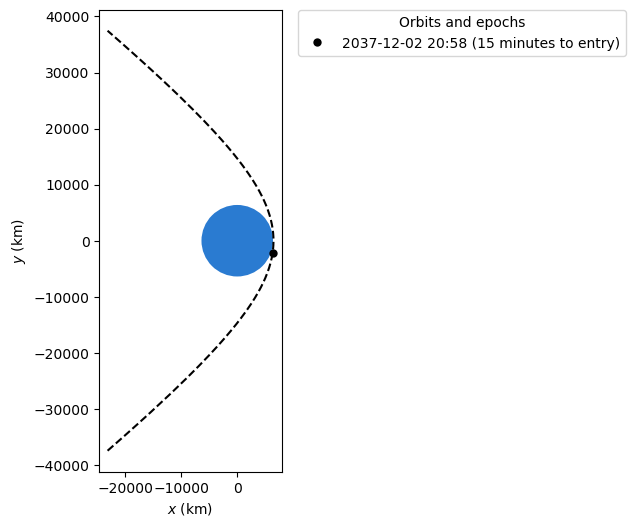

In [41]:

#hyperbolic orb parems
# p = [3495,-12456,0]*u.km
# v = [4.237,10.812,0]*u.km / u.s


#initial_orbit = Orbit.from_vectors(Earth,p,v)
periapsis_orb = initial_orbit.propagate(-180*u.s)
print(f"Speed at periapsis is {np.linalg.norm(initial_orbit.v)}")
print(f"Periapsis is {initial_orbit.r_p-Earth.R}")

earth_ejection_plotter = StaticOrbitPlotter()
earth_ejection_plotter.plot(periapsis_orb, label="15 minutes to entry", color="k")


In [49]:



#Cowell propagation on the entry trajectory

prop_total = 500
reentry_vel = []
reentry_time = []
reentry_alts = []
entry_interface = 0

lift_direction = 90#90 for inverted, -90 for normal, others to take roll into acount


def reentry_accel(accel):
    def constant_accel(t0, state, k):
        v = state[3:]
        square_v = (v[0]**2 + v[1]**2 + v[2]**2) #km^2/s^2
        norm_v = square_v**.5
        p = state[:3]
        alt = 10e-4*(np.linalg.norm(state)*10e2-Earth.R.value)*u.km#alt in km, not sure what these dumbass 1/10th of a metre units are

        global orb_fin
        global entry_interface
        global reentry_vel
        global reentry_time
        global reentry_alts

        if alt<999*u.km:
            density = 0*u.kg/(u.m**3)
            if(alt>0):
                density = atmosphere.properties(alt)[2]#kg/m^3

            #f_d = 0.5*rho*v^2*C_d*a
            # print(f"density at {alt} is {density}")
            # print(square_v)
            #square_v is km^2/s^2 so convert to m^2/s^2, and then convert final acceleration from m/s^2 to km/s^2
            #print((v))
            drag_acc = -0.5*density.value*square_v*10e6*c_d*a_m * v * 10e-3 / (norm_v )# km/s^2
            AoA_lift_rot = R.from_euler('z',lift_direction,degrees=True)
            #lift vector
            lift_vec = AoA_lift_rot.apply(v)
            # print(v)
            # print(f"rotate {lift_vec}")

            # lift_acc = 0*lift_vec
            # if alt<75*u.km:
            lift_acc = 0.5*a_m_l*c_l*square_v*density.value*10e6*lift_vec*10e-3/(norm_v)
            #lift_acc = lift_vec*10e-2/(norm_v)
            # print(f"lift {np.linalg.norm(lift_acc)}")
            # print(f"drag {np.linalg.norm(drag_acc)}")

            print(t0)
            #0.5*10e-11*10e7
            orb_fin = Orbit.from_vectors(Earth, p*u.km, v*u.km/u.s,epoch = date_arrival+t0)
            if alt <120*u.km and entry_interface == 0:
                entry_interface = t0
            if alt <120*u.km:
                reentry_vel.append(norm_v)
                reentry_time.append(t0)
                reentry_alts.append(alt.value)


            #print(acc)
            return 1.0*d_factor*(drag_acc+lift_acc)
        else:
            return 0*v

    return constant_accel



lithobrake_event = LithobrakeEvent(Earth.R.to(u.km).value)
events = [lithobrake_event]  

prop_time = 3000*(u.s)
times = np.linspace(0, prop_time, prop_total)
times
positions = propagate(
    periapsis_orb,
    time.TimeDelta(times),
    method=cowell,
    rtol=1e-10,
    ad=reentry_accel(10e-5),
    events = events
)
impact_time = 0
if entry_interface >0:
    print(f"Entry interface at {entry_interface} seconds")
if lithobrake_event.last_t.to(u.s)< prop_time:
    impact_time = lithobrake_event.last_t.to(u.s)
    print(f"Lithobrake event seen at {lithobrake_event.last_t.to(u.s).value} seconds")






# tofs = time.TimeDelta(np.linspace(0 * u.h, positions.norm().value.size*u.h, num=prop_total))
tofs = np.linspace(0 * u.s, prop_time.to(u.s), num=prop_total)
#pos_spherical = c.cartesian_to_spherical(positions[:][0],positions[:][1],positions[:][2])
pos_spherical = positions.represent_as(SphericalRepresentation)

0.0
2.6600770363776727
0.0034292394013753845
0.005143859102063077
0.007715788653094616
0.018362002179627697
0.02173149236060193
0.016298619270451446
0.02005983910209409
0.04245999276609915
0.03911668624908347
0.055880980355833526
0.06519447708180579
0.06519447708180579
0.006519447708180579
0.013038895416361157
0.050706815508071164
0.09948687109555963
0.11663306810243657
0.14235236361275194
0.24881449887808277
0.28250940068782504
0.22818066978632026
0.2657928681027467
0.48979440474279734
0.45636133957264047
0.6240042806401411
0.7171392478998637
0.7171392478998637
0.13038895416361157
0.19558343124541738
0.5722626321625175
1.060063188037402
1.2315251581061715
1.4887181132093255
2.5533394658626336
2.8902884839600564
2.3470011749450084
2.7231231581092725
4.963138524509779
4.628807872808211
6.305237283483216
7.236586956080442
7.236586956080442
1.3690840187179216
2.0210287895359795
5.7878207987069805
10.665826357455828
12.38044605814352
14.952375609175057
25.59858913570814
28.96807931668237
2

Entry interface at 109.8899880344896 seconds
Exit of entry regime at 298.88923041825734 seconds 
Final apogee of 56059.14141590379 km
Final perigee of 88.5374638346002 km
Energy lost of 21.0809665148647 km2 / s2
Compares to normal ~30km^2/s^2 of LEO reentry


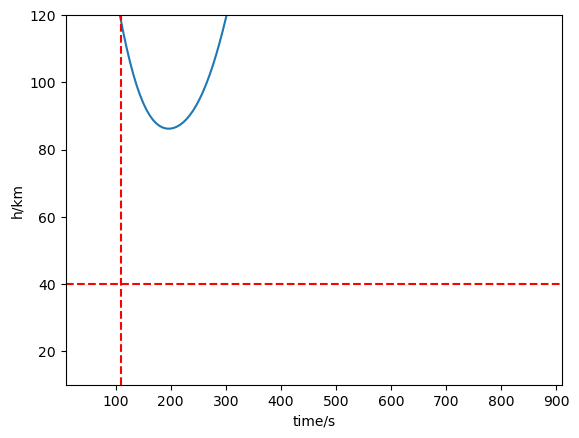

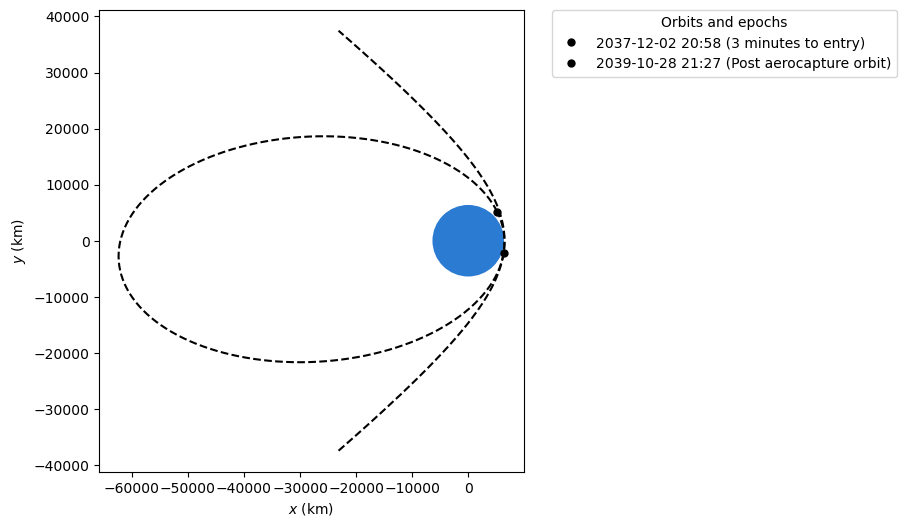

In [43]:
if entry_interface >0:
    print(f"Entry interface at {entry_interface} seconds")
if lithobrake_event.last_t.to(u.s)< prop_time:
    impact_time = lithobrake_event.last_t.to(u.s)
    print(f"Lithobrake event seen at {lithobrake_event.last_t.to(u.s).value} seconds")
else:
    print(f"Exit of entry regime at {reentry_time[len(reentry_time)-1]} seconds ")

print(f"Final apogee of {orb_fin.r_a-Earth.R}")
print(f"Final perigee of {orb_fin.r_p-Earth.R}")
energy_lost = 0.5*(np.linalg.norm(initial_orbit.v)**2-np.linalg.norm(orb_fin.v)**2)
print(f"Energy lost of {energy_lost}")
print(f"Compares to normal ~30km^2/s^2 of LEO reentry")


plt.ylabel("h/km")
# plt.xlabel("distance downrange, km")
plt.xlabel("time/s")
#plt.axhline(impact_time)

#plt.xlim(12500,14000)
#plt.ylim(top = 100)
plt.plot(tofs, pos_spherical.distance - Earth.R)
plt.xlim(left=entry_interface-100,right=entry_interface+800)
plt.axvline(x=entry_interface,color = 'r',label='entry_interface',linestyle = '--')
plt.axhline(y=40,color = 'r',label='entry_interface',linestyle = '--')
plt.ylim(bottom = 10,top=120)
#plt.axvline(x=entry_interface,color = 'r',label='entry_interface')
plt.show()

final_orb_plotter = StaticOrbitPlotter()
final_orb_plotter.plot(periapsis_orb, label="3 minutes to entry", color="k")
final_orb_plotter.plot(orb_fin, label="Post aerocapture orbit", color="k")


In [44]:
#calculate the accelerations
reentry_accs = np.diff(np.array(reentry_vel))/np.diff(np.array(reentry_time)+1)


C:\Users\jacki\AppData\Local\Temp\ipykernel_27272\2518044004.py:2: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\jacki\AppData\Local\Temp\ipykernel_27272\2518044004.py:2: RuntimeWarning:

invalid value encountered in true_divide



Entry interface at 109.8899880344896 seconds


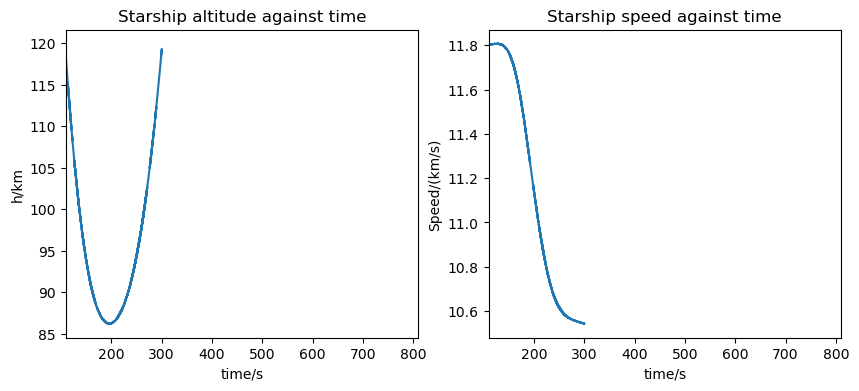

In [45]:
impact_time = 0
if entry_interface >0:
    print(f"Entry interface at {entry_interface} seconds")
if lithobrake_event.last_t.to(u.s)< prop_time:
    impact_time = lithobrake_event.last_t.to(u.s)
    print(f"Lithobrake event seen at {lithobrake_event.last_t.to(u.s).value} seconds")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


ax1.set_ylabel("h/km")
# plt.xlabel("distance downrange, km")
ax1.set_title("Starship altitude against time")
ax1.set_xlabel("time/s")
ax1.set_xlim(left = entry_interface, right=entry_interface+700)
#plt.xlim(12500,14000)
#plt.ylim(top = 100)
#print(reentry_alts)
#plt.ylim(150)
ax1.plot(np.array(reentry_time),np.array(reentry_alts))
#drag 0.47813373175961593 hours
#none 0.4863379477979069 hours
#print(np.array(reentry_vel)[15])
#plt.ylim(15)
ax2.set_title("Starship speed against time")
ax2.set_xlabel("time/s")
ax2.set_ylabel("Speed/(km/s)")
ax2.set_xlim(left = entry_interface, right=entry_interface+700)
ax2.plot(np.array(reentry_time),np.array(reentry_vel))


[        nan        -inf  0.00062086 ... -0.0006676  -0.00066623
 -0.00066531]


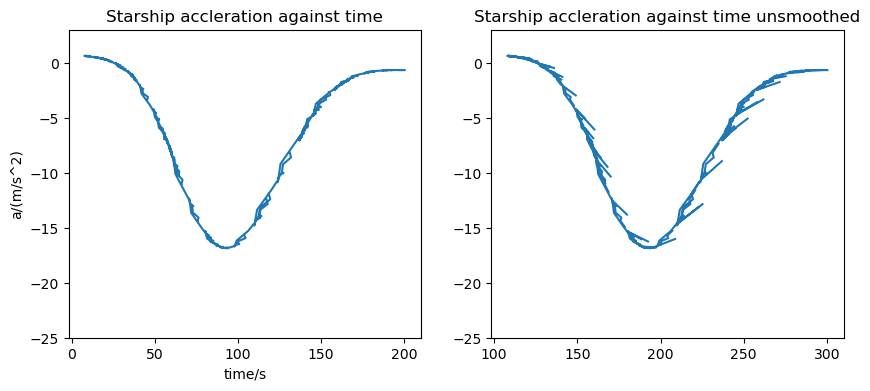

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


from scipy.signal import savgol_filter

def smooth_data(data, window_length=3, polyorder=2):
    """
    Smoothes the input data using a Savitzky-Golay filter.

    Parameters:
        data (array-like): The data to be smoothed (e.g., acceleration values).
        window_length (int): Length of the filter window (must be odd and > polyorder).
        polyorder (int): Order of the polynomial used to fit the samples.

    Returns:
        smoothed_data (ndarray): The smoothed data.
    """
    # Ensure window_length is odd and valid
    if window_length % 2 == 0:
        window_length += 1
    
    # Apply Savitzky-Golay filter
    smoothed_data = savgol_filter(data, window_length=window_length, polyorder=polyorder)
    print(smoothed_data)
    return smoothed_data

reentry_accs_smooth = smooth_data(np.array(reentry_accs))

ax1.set_ylabel("a/(m/s^2)")
# plt.xlabel("distance downrange, km")
ax1.set_xlabel("time/s")
#plt.xlim(12500,14000)
#plt.ylim(top = 100)
#print(reentry_alts)
#plt.ylim(150)
#ax1.set_xlim(2600)
ax1.set_title("Starship accleration against time")
ax1.set_ylim(top = 3, bottom = -25)
ax1.plot(np.array(reentry_time)[:-1]-100,reentry_accs_smooth*1000)
ax2.set_title("Starship accleration against time unsmoothed")
ax2.set_ylim(top = 3, bottom = -25)
ax2.plot(np.array(reentry_time)[:-1],np.array(reentry_accs)*1000)
#print(np.array(reentry_time))
